In [1]:
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
import qiskit.quantum_info as qi
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

In [2]:
# %matplotlib inline
# !pip install --quiet noisyopt
# !pip install --quiet numba --upgrade --user
# !pip install --quiet pennylane-sf --upgrade
from noisyopt import minimizeSPSA
import numpy as np
import itertools

(0) Load the dataset and process it likewise the classical method
======================

In [3]:
import classical

2022-12-04 21:43:48.398299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 21:43:48.584240: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-04 21:43:48.589351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 21:43:48.589397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [4]:
sequence_length = 5
x_train, y_train, x_val, y_val, x_test, y_test = \
    classical.get_data(sequence_length, n_stocks_train=100, n_stocks_val=64)

100%|██████████| 228/228 [00:01<00:00, 130.13it/s]


Preprocessing Data


(1) First consider the case with only 1 feature (closed price). Normalize our feature x_1. 
======================
Our current data encoding method (from a floating point number to an angle), requires the floating number between (0,1]. So we need to first process the data using min-max normalization (like what we did to the volumn)


(2) Encode the normalized feature into an angle
======================

$$x_i` = \sqrt{(1-x_i^2)}$$
$$ angle \space \phi = \arctan{(x`_i/x_i)}$$

In [5]:
print(x_train[0].shape)

(5,)


In [6]:
def contant_baseline():
  pred_value = 0
  for y in y_train:
    pred_value += y[-1]
  pred_value /= len(y_train)
  print(pred_value)

  for name, test_set in ("train", y_train), ("Val", y_val), ("Test", y_test):
    losses = []
    print(f"N datapoints: {len(test_set)}")
    for y in test_set:
        losses.append((y[-1] - pred_value) ** 2)
    print(f"{name} Loss: {np.mean(losses)}")
classical.contant_baseline(y_train, y_val, y_test)

2.0199111219868064
N datapoints: 100
train Loss: 3.530376554078775
N datapoints: 64
Val Loss: 2.932090762668322
N datapoints: 64
Test Loss: 3.1556735697696907


2.0199111219868064

In [7]:
import tensorflow as tf
num_hidden = 64
classical.tf_baseline(num_hidden, sequence_length, x_train, y_train, x_val, y_val, x_test, y_test)

2022-12-04 21:43:53.855953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 21:43:53.855973: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 21:43:53.855989: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alex-Laptop): /proc/driver/nvidia/version does not exist
2022-12-04 21:43:53.856223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 3s 201ms/step - loss: 1.8160 - mse: 7.6679 - val_loss: 1.6679 - val_mse: 6.4379
Epoch 2/30
4/4 [==============================] - 0s 10ms/step - loss: 1.7177 - mse: 7.0976 - val_loss: 1.5642 - val_mse: 5.9322
Epoch 3/30
4/4 [==============================] - 0s 10ms/step - loss: 1.6201 - mse: 6.5666 - val_loss: 1.4448 - val_mse: 5.3882

In [8]:
def float_to_angle(x):
    return classical.bounded_map(x) # send to -pi, pi

# Angles all have shape [batch, timesteps]
train_angles = np.array([float_to_angle(x) for x in x_train])
val_angles = np.array([float_to_angle(x) for x in x_val])
test_angles = np.array([float_to_angle(x) for x in x_test])    


train_angles_y = np.array([float_to_angle(y) for y in y_train])
val_angles_y = np.array([float_to_angle(y) for y in y_val])
test_angles_y = np.array([float_to_angle(y) for y in y_test])
assert np.all(-np.pi <= train_angles)
assert np.all(train_angles <= np.pi)

(3) Input the angle into Displacement gate
===========================
Input the angle into Displacement gate, to eventually integrate our features to the circuit. \
Reference of the Displacement gate: https://docs.pennylane.ai/en/stable/code/api/pennylane.Displacement.html \
Our current circuit is the one in "Rapid training of QRNN". Displacement gate is the D gate in the following figure. \
The I gate in the figure has been modeled by Luis into combination of basis gates (which can be found in the APIs in Pennylane). So we can first implement the circuit. Because Pennylane and Xanadu are proposed by the same company, we think that it will be smooth to run the code on Xanadu, after running on LocalSimulator.

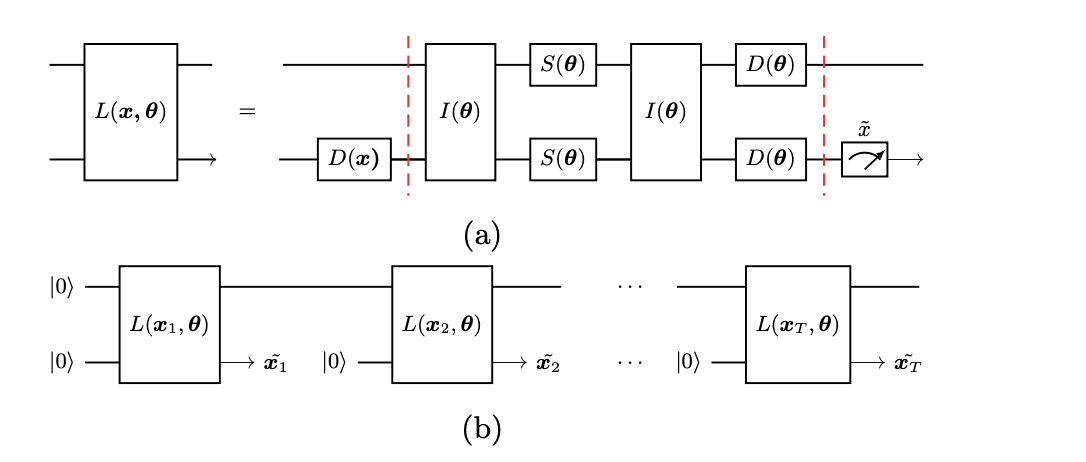

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the
variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [9]:
depth = 1
q_wires = 2
combs = itertools.combinations(range(q_wires), 2)

def vqc_unit(params,qc,theta):
    # Encoding
    qc.u(theta,0,0,1)
    
    # qc.barrier()
    # Interaction
    for m in range(depth + 1):
        for i in range(q_wires):
            qc.u(params[m, i, 0], params[m, i, 1], params[m, i, 2],i)
        if m != depth:
            qc.cx(1,0)

backend = Aer.get_backend('aer_simulator')
# it's a multi-to-one Quantum RNN
def circuit_vqc(weights, theta):
    circuit = QuantumCircuit(q_wires,2)
    #print("len of theta: ", len(theta)) # which is == length of time series
    for i in range(len(theta)-1):
        vqc_unit(weights,circuit,theta[i])
        circuit.reset([1])

    vqc_unit(weights,circuit,theta[-1])   
    circuit.measure([1], [0])
    run_result = execute(circuit, backend=backend,shots=n_shots).result()
    # transpiled_circuit = transpile(circuit, backend)
    # run_result = backend.run(transpiled_circuit, shots=shots).result()

    simp_counts0 = marginal_counts(run_result, indices=[0]).get_counts()

    # label y -> theta_y, so prediction = 2 cos^-1(amplitude of |0>)? 
    num_ones = simp_counts0['1'] if '1' in simp_counts0 else 0
    # Multiply by slightly less than pi so we don't ever predict infinity
    return np.tan((num_ones/n_shots - .5) * 2.75)


In [10]:
np.random.seed(2)
num_qubits = 2
num_layers = 1
n_wires = 2
weights_init_qaoa = 2 * np.pi * np.random.uniform(-1, 1, size=(depth + 1, n_wires, 3))
# weights_4_val = np.array([ 13.26030476,  -4.85954186,  -1.48417534,  -0.57736945,
#          4.6643797 ,  -1.18933862,   4.95008181,  13.32304439,
#         -4.64256665,  -2.89863502,   4.90275961, -13.28259991])
# weights_init_qaoa = np.array(weights_4_val)
train_costs = []
val_costs = []
cur_weights = weights_init_qaoa.flatten().copy()
iteration_num = 0
val_freq = 5
best_val = 100
best_val_w = cur_weights

In [11]:
close_ind = 3
def get_open_only(x_data):
    return [x_datapoint[:, close_ind] for x_datapoint in x_data]
x_train = get_open_only(x_train)
x_val = get_open_only(x_val)
x_test = get_open_only(x_test)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def square_loss(labels, predictions):
    loss = []
    for l, p in zip(labels, predictions):
      l = classical.inv_bounded_map(l)
      loss.append((l - p) ** 2)
    loss = np.mean(loss)
    return loss

In [ ]:
# https://pennylane.ai/qml/demos/spsa.html
# in our temporal experiment, we select 50 stocks
# each stock has 10 data points
def cost_spsa(weights, seed=0):
    np.random.seed(seed)
    batch_inds = np.random.randint(train_angles.shape[0], size=batch_size)
    
    # X contains a time series of every stock
    X = train_angles[batch_inds, :]
    weights = weights.reshape(weights_init_qaoa.shape)
    predictions = [circuit_vqc(weights, x) for x in X] 
    loss = square_loss(train_angles_y[batch_inds, -1], predictions)
    train_costs.append(loss)
    return loss

def val_cost(weights, X=val_angles, y=val_angles_y):
  weights = weights.reshape(weights_init_qaoa.shape)
  predictions = [circuit_vqc(weights, x) for x in X] 
  return square_loss(y[:, -1], predictions)

def callback_fn(w):
    global iteration_num, best_val, best_val_w

    iteration_num += 1
    if (iteration_num - 1) % val_freq == 0:
      val_loss = val_cost(w)
      val_costs.append(val_loss)

      print(
          f"Iteration = {iteration_num}, "
          f"Val Loss = {val_loss} "
          f"Train Loss = {np.mean(train_costs[-val_freq:-1])}"
      )
      if val_loss < best_val:
        best_val_w = w.copy()
        best_val = val_loss
        print("Update best val w")

In [ ]:
import time
batch_size = 64
n_shots = 50
st = time.time()
# Just run it indefinitely
for i in range(1000):
  step_length = .02 / (1 +  i * .05)
  n_shots = 50 + i
  res = minimizeSPSA(
      cost_spsa,
      x0=cur_weights,
      niter=10,
      paired=True,
      c=0.15,
      a=step_length,
      callback=callback_fn,
  )
  cur_weights = res.x
  end = time.time()
  print(f"Seconds: {end - st}")

KeyboardInterrupt: 

In [ ]:
print(repr(best_val_w))
print(f"Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")

array([-0.80431178, -5.95738667,  0.6240771 , -0.81276278, -1.00068771,
       -2.13207552, -3.71149473,  1.49880317, -2.51761362, -2.93013488,
        1.52221264,  0.36621036])
Cost Val 5.26157757263581 Test 4.390222909503673


In [ ]:
train_costs_smooth = np.convolve(train_costs, np.ones(40), 'valid') / 40

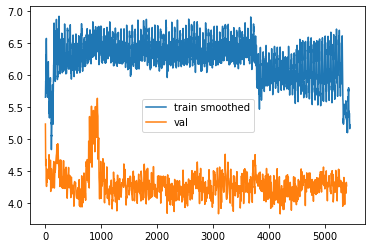

Run 1: Cost Val 4.37756920506593 Test 3.9956819197684608
Run 2: Cost Val 4.187666020120006 Test 4.132757363657063
Run 3: Cost Val 4.05392193207215 Test 3.8488427361410387


In [ ]:
import matplotlib.pyplot as plt
# plt.plot(train_costs[::2], label='train')
plt.plot(train_costs_smooth[::2], label='train smoothed')
plt.plot(range(0, len(val_costs) * val_freq, val_freq), val_costs, label='val')
plt.legend()
plt.show()

In [ ]:
# Run 3 times because it will be different each time due to randomness...
print(f"Run 1: Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")
print(f"Run 2: Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")
print(f"Run 3: Cost Val {val_cost(best_val_w, val_angles, val_angles_y)} Test {val_cost(best_val_w, test_angles, test_angles_y)}")

Run 1: Cost Val 10.07232436764409 Test 7.9836558165131635
Run 2: Cost Val 10.864045115683094 Test 8.19009876696172
Run 3: Cost Val 10.464240324995622 Test 7.956823247930263


end
==============